## Loading the dataset

In [151]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
# Load your dataset
data = pd.read_excel(r'C:\Users\Sajin Siyad\Documents\Saju\UCC\EC6011 - Business Forecasting\Project\dataset\Monthly_forecasting dataset.xlsx')  
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%B')
data.drop(['Year', 'Month'], axis=1, inplace=True)
# Reorder columns to make 'Date' the first column (useful if more columns are present)
data = data[['Date'] + [col for col in data.columns if col != 'Date']]
data.set_index('Date', inplace=True)
data
# Display first few rows to verify data
data.head()



,CPI_Home,Nominal Exchange Rate,Real Exchange Rate,CPI_Foreign,log_NER,log_CPI_Home,log_CPI_Foreign,log_RER
Date,,,,,,,,
2013-01-01,128.155340,54.251652,45.094921,106.524958,3.993633,4.853243,4.668379,3.808770
2013-02-01,129.975728,53.823100,44.351634,107.103380,3.985703,4.867348,4.673795,3.792150
2013-03-01,130.218447,54.406659,44.623107,106.802214,3.996487,4.869213,4.670979,3.798252
2013-04-01,130.703883,54.359826,44.326361,106.579214,3.995625,4.872934,4.668888,3.791580
2013-05-01,131.432039,54.997174,44.616086,106.623354,4.007282,4.878490,4.669303,3.798094


## Descriptive Statistics

In [152]:
data.describe()

,CPI_Home,Nominal Exchange Rate,Real Exchange Rate,CPI_Foreign,log_NER,log_CPI_Home,log_CPI_Foreign,log_RER
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,177.562871,70.644353,48.060681,120.290088,4.251230,5.164980,4.784876,3.871125
std,30.367953,8.025665,2.519336,12.385874,0.113962,0.169595,0.099517,0.051694
min,128.155340,53.823100,43.691067,106.524958,3.985703,4.853243,4.668379,3.777144
25%,153.792476,64.445419,46.448575,109.444659,4.165819,5.035601,4.695419,3.838346
50%,169.963592,69.718163,47.471899,116.222274,4.244460,5.135584,4.755505,3.860138
75%,201.729369,75.693403,49.321888,129.312882,4.326691,5.306926,4.862231,3.898367
max,237.378641,84.994318,53.143622,146.032425,4.442584,5.469657,4.983829,3.972998


## Visualising log variables


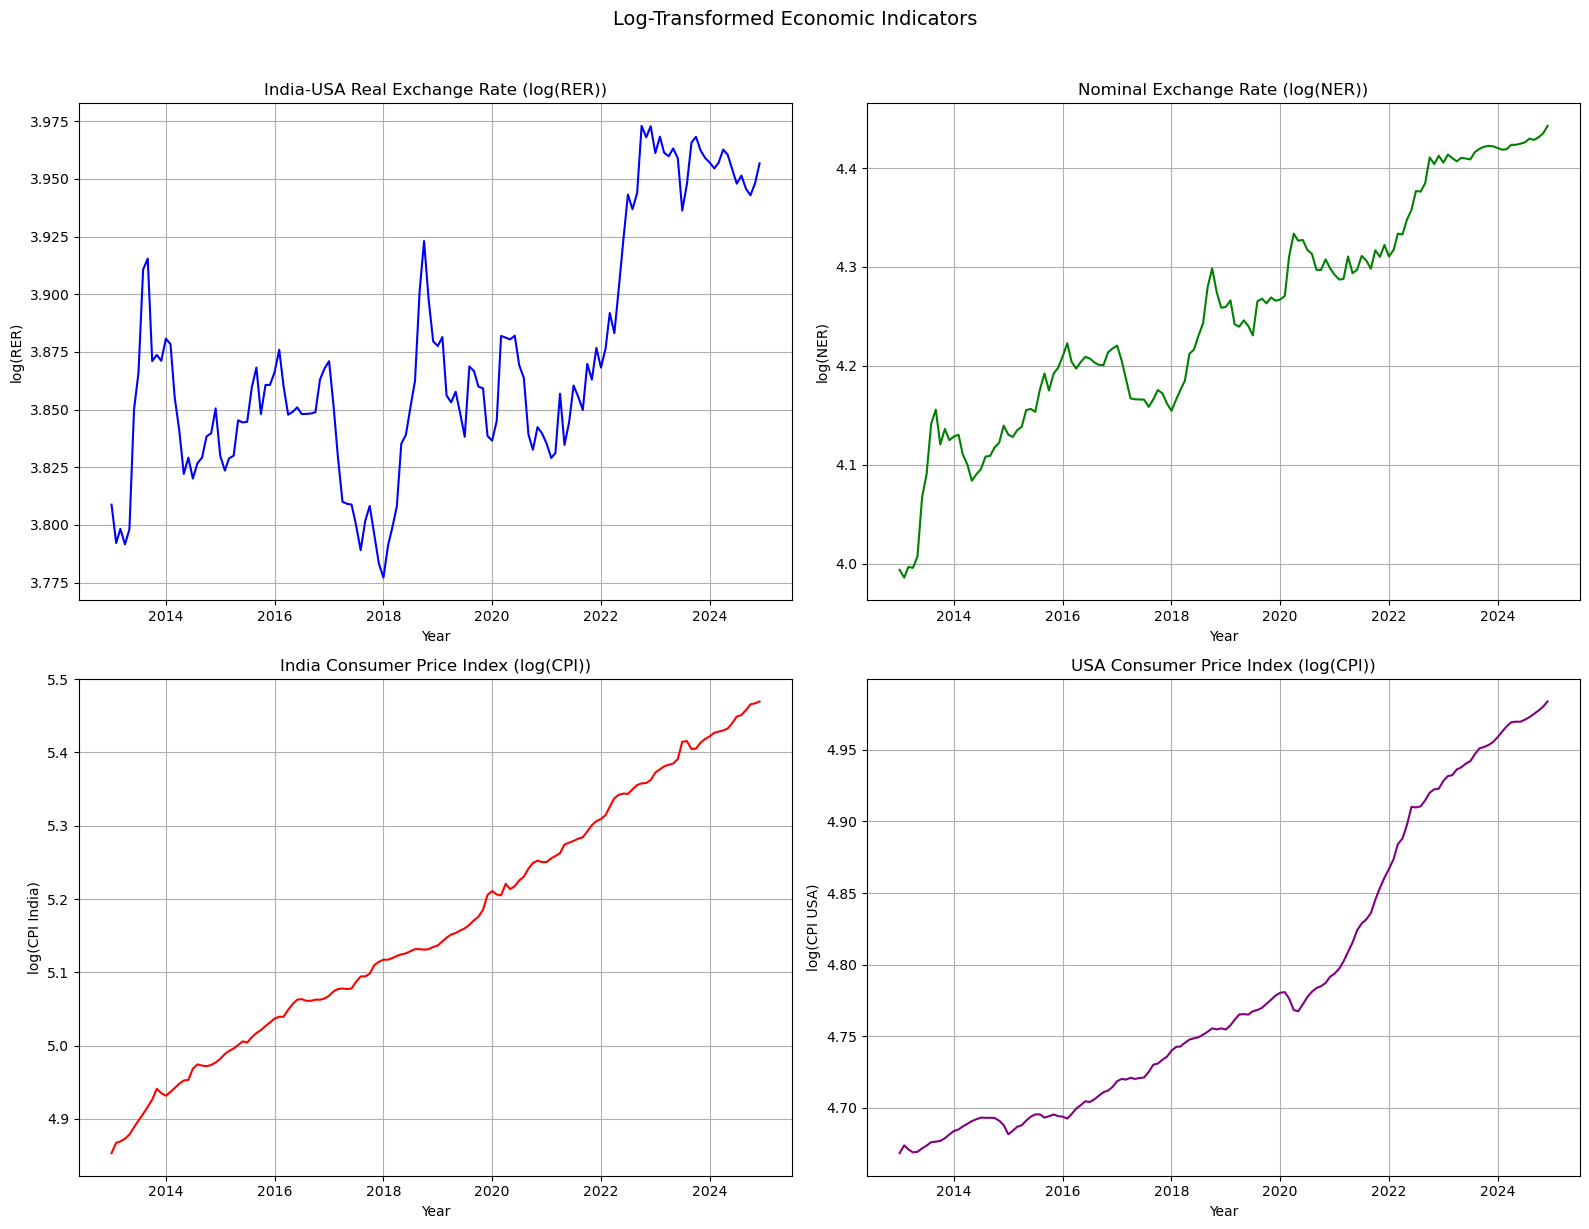

In [153]:
# Create a 2x2 grid of plots for visual inspection
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Log-Transformed Economic Indicators', y=1.02, fontsize=14)

# Plot 1: log(RER)
axes[0,0].plot(data['log_RER'], color='blue')
axes[0,0].set_title('India-USA Real Exchange Rate (log(RER))')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('log(RER)')
axes[0,0].grid(True)

# Plot 2: log(NER)
axes[0,1].plot(data['log_NER'], color='green')
axes[0,1].set_title('Nominal Exchange Rate (log(NER))')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('log(NER)')
axes[0,1].grid(True)

# Plot 3: log(CPI_home) - India
axes[1,0].plot(data['log_CPI_Home'], color='red')
axes[1,0].set_title('India Consumer Price Index (log(CPI))')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('log(CPI India)')
axes[1,0].grid(True)

# Plot 4: log(CPI_foreign) - USA
axes[1,1].plot(data['log_CPI_Foreign'], color='purple')
axes[1,1].set_title('USA Consumer Price Index (log(CPI))')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('log(CPI USA)')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


### Training and Testing split

In [155]:
## Split into train (2013-2023) and test (2024) sets
train = data['log_RER'].loc['2013-01-01':'2023-12-01']
test = data['log_RER'].loc['2024-01-01':]

## ***********************************************

## Stationarity test (ADF test)

In [158]:
def adf_test(series, name):
    """Perform ADF test and print results"""
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] > 0.05:
        print(f"Conclusion: {name} is NON-STATIONARY")
    else:
        print(f"Conclusion: {name} is STATIONARY")
    return result[1]

# Test stationarity of log_RER
p_value = adf_test(data['log_RER'], 'log_RER')

# If non-stationary, take first differences
if p_value > 0.05:
    print("\nTaking first differences to make series stationary...")
    data['diff_log_RER'] = data['log_RER'].diff()
    p_value_diff = adf_test(data['diff_log_RER'], 'diff_log_RER')




ADF Test for log_RER:
Test Statistic: -1.8868
p-value: 0.3383
Critical Values:
   1%: -3.4773
   5%: -2.8821
   10%: -2.5777
Conclusion: log_RER is NON-STATIONARY

Taking first differences to make series stationary...

ADF Test for diff_log_RER:
Test Statistic: -10.3079
p-value: 0.0000
Critical Values:
   1%: -3.4773
   5%: -2.8821
   10%: -2.5777
Conclusion: diff_log_RER is STATIONARY


#### Visualising Differenced log(RER)

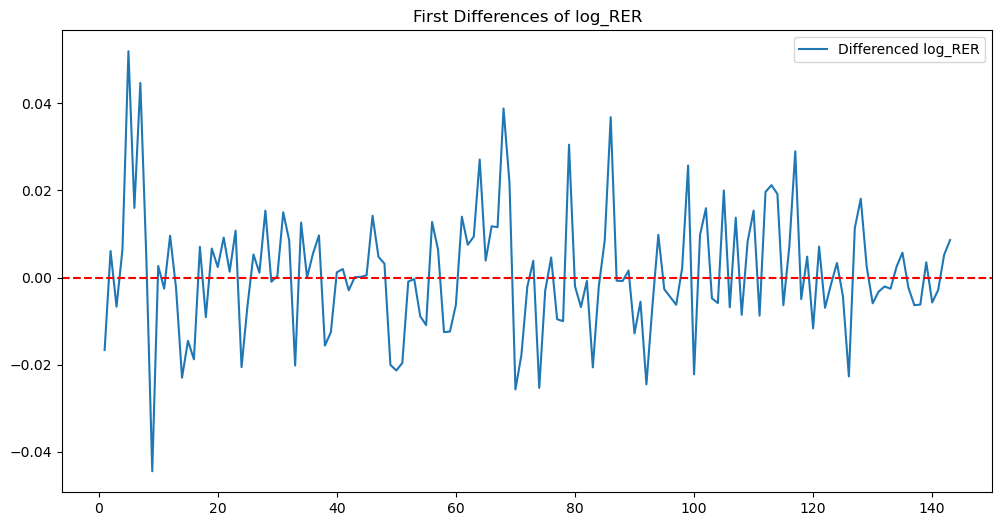

In [241]:
plt.figure(figsize=(12,6))
plt.plot(data['log_RER'].diff().dropna(), label='Differenced log_RER')
plt.axhline(0, color='red', linestyle='--')
plt.title('First Differences of log_RER')
plt.legend()
plt.show()

In [157]:
# for report
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    """Perform ADF test and return formatted results"""
    result = adfuller(series.dropna())
    return {
        'Variable': name,
        'Test Statistic': round(result[0], 4),
        'p-value': round(result[1], 4),
        '1% Critical': round(result[4]['1%'], 4),
        '5% Critical': round(result[4]['5%'], 4),
        '10% Critical': round(result[4]['10%'], 4),
        'Conclusion': 'STATIONARY' if result[1] < 0.05 else 'NON-STATIONARY'
    }

# List of variables to test
variables = ['log_RER', 'log_NER', 'log_CPI_Home', 'log_CPI_Foreign']
results = []

# Test stationarity and differences
for var in variables:
    # Test level
    level_result = adf_test(data[var], var)
    results.append(level_result)
    
    # If non-stationary, test first difference
    if level_result['p-value'] > 0.05:
        diff_var = f'diff_{var}'
        data[diff_var] = data[var].diff()
        diff_result = adf_test(data[diff_var], diff_var)
        results.append(diff_result)
        
        # If first difference is still non-stationary, test second difference
        if diff_result['p-value'] > 0.05:
            diff2_var = f'diff2_{var}'
            data[diff2_var] = data[var].diff().diff()
            diff2_result = adf_test(data[diff2_var], diff2_var)
            results.append(diff2_result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Format table (rest of your styling code remains the same)

# Format table for better presentation
styled_table = (results_df.style
                .format({'Test Statistic': '{:.4f}', 
                         'p-value': '{:.4f}',
                         '1% Critical': '{:.4f}',
                         '5% Critical': '{:.4f}',
                         '10% Critical': '{:.4f}'})
                .set_properties(**{'text-align': 'left'})
                .set_caption('ADF Stationarity Test Results')
                .highlight_between(left=0.05, right=1, 
                                 subset=['p-value'], 
                                 props='color:red;')
                .highlight_between(left=0, right=0.05,
                                 subset=['p-value'],
                                 props='color:green;'))

# Display results
print("\nComplete Stationarity Test Results:")
display(styled_table)

# Save to LaTeX for academic papers
results_df.to_latex('adf_results.tex', index=False, float_format="%.4f")


Complete Stationarity Test Results:


,Variable,Test Statistic,p-value,1% Critical,5% Critical,10% Critical,Conclusion
0,log_RER,-1.8868,0.3383,-3.4773,-2.8821,-2.5777,NON-STATIONARY
1,diff_log_RER,-10.3079,0.0000,-3.4773,-2.8821,-2.5777,STATIONARY
2,log_NER,-1.5399,0.5137,-3.4769,-2.8820,-2.5777,NON-STATIONARY
3,diff_log_NER,-10.1324,0.0000,-3.4773,-2.8821,-2.5777,STATIONARY
4,log_CPI_Home,-0.1896,0.9397,-3.4776,-2.8823,-2.5778,NON-STATIONARY
5,diff_log_CPI_Home,-10.5027,0.0000,-3.4776,-2.8823,-2.5778,STATIONARY
6,log_CPI_Foreign,0.5602,0.9866,-3.4794,-2.8830,-2.5782,NON-STATIONARY
7,diff_log_CPI_Foreign,-2.1562,0.2225,-3.4794,-2.8830,-2.5782,NON-STATIONARY
8,diff2_log_CPI_Foreign,-8.6531,0.0000,-3.4794,-2.8830,-2.5782,STATIONARY


## Cointegration test

In [159]:
from statsmodels.tsa.stattools import coint
import pandas as pd

# Define pairs to test (Y, X)
coint_pairs = [
    ('log_NER', 'log_RER'),
    ('log_CPI_Home', 'log_RER'),
    ('log_CPI_Foreign', 'log_RER')
]

# Initialize results storage
coint_results = []

# Perform cointegration tests
for y_var, x_var in coint_pairs:
    try:
        # Check if variables exist in data
        if y_var in data.columns and x_var in data.columns:
            # Perform cointegration test
            test_stat, p_value, crit_values = coint(data[y_var], data[x_var])
            
            # Store results
            coint_results.append({
                'Dependent (Y)': y_var,
                'Independent (X)': x_var,
                'Test Statistic': round(test_stat, 4),
                'p-value': round(p_value, 4),
                '1% Critical': round(crit_values[0], 4),
                '5% Critical': round(crit_values[1], 4),
                '10% Critical': round(crit_values[2], 4),
                'Conclusion': 'COINTEGRATED*' if p_value < 0.05 else 'Not Cointegrated'
            })
        else:
            print(f"Warning: {y_var} or {x_var} not found in dataset")
    except Exception as e:
        print(f"Error testing {y_var} vs {x_var}: {str(e)}")

# Convert to DataFrame
coint_df = pd.DataFrame(coint_results)

# Format table for better presentation
styled_coint_table = (
    coint_df.style
    .format({
        'Test Statistic': '{:.4f}',
        'p-value': '{:.4f}',
        '1% Critical': '{:.4f}',
        '5% Critical': '{:.4f}',
        '10% Critical': '{:.4f}'
    })
    .set_properties(**{'text-align': 'left'})
    .set_caption('Cointegration Test Results')
    .highlight_between(
        subset=['p-value'], 
        left=0, 
        right=0.05, 
        props='color:green; font-weight:bold;'
    )
    .hide(axis='index')  # Hide row numbers
)

# Display results
print("\n=== Cointegration Analysis ===")
display(styled_coint_table)

# Save to LaTeX for academic papers
coint_df.to_latex('cointegration_results.tex', index=False, float_format="%.4f")

# Interpretation note
print("\n*Note: Cointegrated pairs indicate a long-run equilibrium relationship exists")
print("when p-value < 0.05 (reject null hypothesis of no cointegration)")


=== Cointegration Analysis ===


Dependent (Y),Independent (X),Test Statistic,p-value,1% Critical,5% Critical,10% Critical,Conclusion
log_NER,log_RER,-1.9807,0.5386,-3.9747,-3.3792,-3.0742,Not Cointegrated
log_CPI_Home,log_RER,-2.0608,0.4969,-3.9747,-3.3792,-3.0742,Not Cointegrated
log_CPI_Foreign,log_RER,-2.5167,0.2717,-3.9747,-3.3792,-3.0742,Not Cointegrated



*Note: Cointegrated pairs indicate a long-run equilibrium relationship exists
when p-value < 0.05 (reject null hypothesis of no cointegration)


## Testing validity for absolute ppp and relative ppp

In [162]:
# Absolute PPP - log(NERt)=α+β(log(CPI USA,t)−log(CPIIndia,t))+ut
import statsmodels.api as sm

X = data['log_CPI_Foreign'] - data['log_CPI_Home']
X = sm.add_constant(X)  # Adds intercept (α)
model_absolute = sm.OLS(data['log_NER'], X).fit()
print(model_absolute.summary())

# Test residuals for stationarity (ADF)
residuals = model_absolute.resid
adf_test(residuals, 'Absolute PPP Residuals')

                            OLS Regression Results                            
Dep. Variable:                log_NER   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     818.8
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           8.05e-61
Time:                        01:07:25   Log-Likelihood:                 246.58
No. Observations:                 144   AIC:                            -489.2
Df Residuals:                     142   BIC:                            -483.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7370      0.018    203.765      0.0

0.191481594128876

In [204]:
import pandas as pd

# Create the results table
absolute_ppp_results = pd.DataFrame({
    'Component': ['Intercept (α)', 'CPI Differential Coefficient (β)', 
                  'R-squared', 'ADF Test Statistic (Residuals)', 
                  'ADF p-value (Residuals)', 'Durbin-Watson Statistic'],
    'Estimated Value': [3.7370, -1.3528, 0.852, -2.2416, 0.1915, 0.114],
    'Theoretical (PPP)': [0, 1, "-", "Stationary (p < 0.05)", "-", "2 (no autocorrelation)"],
    'Implication': [
        "Rupee overvaluation (α ≠ 0)", 
        "Inverse relationship (β ≠ 1)", 
        "High explanatory power but wrong relationship", 
        "Non-stationary residuals (p > 0.05)", 
        "No long-run equilibrium", 
        "Strong autocorrelation in deviations"
    ]
})

# Style the table for publication
styled_table = (absolute_ppp_results.style
    .hide(axis='index')
    .format({
        'Estimated Value': "{:.4f}",
        'ADF p-value (Residuals)': "{:.4f}"
    })
    .map(lambda x: 'color: red' if x in ['Non-stationary residuals (p > 0.05)', 
                                             'Inverse relationship (β ≠ 1)'] 
              else ('color: green' if x == 'High explanatory power' else ''), 
              subset=['Implication'])
    .set_caption("Table 1: Absolute PPP Test Results (India-US)")
    .set_properties(**{'text-align': 'left',
                      'font-size': '12pt',
                      'font-family': 'Times New Roman'})
    .set_table_styles([
        {'selector': 'caption', 
         'props': [('font-weight', 'bold'), 
                   ('font-size', '14pt'),
                   ('text-align', 'center')]},
        {'selector': 'th', 
         'props': [('background-color', '#f7f7f7'),
                   ('font-weight', 'bold')]}
    ]))

# Display and save
display(styled_table)

# Save to LaTeX for academic papers
absolute_ppp_results.to_latex('absolute_ppp_table.tex', 
                             index=False, 
                             float_format="%.4f",
                             caption="Absolute PPP Test Results (India-US)",
                             label="tab:absolute_ppp")

Component,Estimated Value,Theoretical (PPP),Implication
Intercept (α),3.7370,0,Rupee overvaluation (α ≠ 0)
CPI Differential Coefficient (β),-1.3528,1,Inverse relationship (β ≠ 1)
R-squared,0.8520,-,High explanatory power but wrong relationship
ADF Test Statistic (Residuals),-2.2416,Stationary (p < 0.05),Non-stationary residuals (p > 0.05)
ADF p-value (Residuals),0.1915,-,No long-run equilibrium
Durbin-Watson Statistic,0.1140,2 (no autocorrelation),Strong autocorrelation in deviations


In [165]:
# Relative PPP
data['delta_log_NER'] = data['log_NER'].diff()
data['delta_inflation_diff'] = data['log_CPI_Foreign'].diff() - data['log_CPI_Home'].diff()

X_diff = sm.add_constant(data['delta_inflation_diff'].dropna())
model_relative = sm.OLS(data['delta_log_NER'].dropna(), X_diff).fit()
print(model_relative.summary())

                            OLS Regression Results                            
Dep. Variable:          delta_log_NER   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4679
Date:                Thu, 10 Apr 2025   Prob (F-statistic):              0.495
Time:                        01:07:26   Log-Likelihood:                 413.48
No. Observations:                 143   AIC:                            -823.0
Df Residuals:                     141   BIC:                            -817.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0028 

In [206]:
# Create results table for Relative PPP
relative_ppp_results = pd.DataFrame({
    'Component': ['Intercept (γ)', 
                  'Inflation Differential Coefficient (δ)',
                  'R-squared',
                  'F-statistic (p-value)',
                  'Durbin-Watson',
                  'Jarque-Bera (p-value)'],
    'Estimated Value': [0.0028, 
                       -0.1485, 
                       0.003, 
                       f"0.4679 (p={0.495:.3f})", 
                       1.688, 
                       f"56.480 (p={5.44e-13:.2e})"],
    'Theoretical (PPP)': ['-', 
                          '1', 
                          '-', 
                          'Significant (p<0.05)', 
                          '2 (no autocorrelation)', 
                          '>0.05 (normal residuals)'],
    'Implication': [
        'Small but significant drift (p=0.022)',
        'No relationship (p=0.495), opposite of PPP prediction',
        'Virtually no explanatory power',
        'Overall model insignificant',
        'Mild positive autocorrelation',
        'Non-normal residuals (leptokurtic)'
    ]
})

# Style the table
styled_relative_table = (relative_ppp_results.style
    .hide(axis='index')
    .format({'Estimated Value': "{:.4f}"}, subset=pd.IndexSlice[[0,1], 'Estimated Value'])
    .map(lambda x: 'color: red' if 'opposite' in x or 'no relationship' in x 
         else ('color: orange' if 'non-normal' in x else ''), 
         subset=['Implication'])
    .set_caption("Table 2: Relative PPP Test Results (India-US)")
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'caption', 
         'props': [('font-weight', 'bold'), 
                   ('font-size', '14pt')]},
        {'selector': 'th', 
         'props': [('background-color', '#f7f7f7')]}
    ]))

# Display and save
display(styled_relative_table)
relative_ppp_results.to_latex('relative_ppp_table.tex', 
                             index=False, 
                             float_format="%.4f",
                             caption="Relative PPP Test Results (India-US)")

Component,Estimated Value,Theoretical (PPP),Implication
Intercept (γ),0.0028,-,Small but significant drift (p=0.022)
Inflation Differential Coefficient (δ),-0.1485,1,"No relationship (p=0.495), opposite of PPP prediction"
R-squared,0.003000,-,Virtually no explanatory power
F-statistic (p-value),0.4679 (p=0.495),Significant (p<0.05),Overall model insignificant
Durbin-Watson,1.688000,2 (no autocorrelation),Mild positive autocorrelation
Jarque-Bera (p-value),56.480 (p=5.44e-13),>0.05 (normal residuals),Non-normal residuals (leptokurtic)


## ACF and PACF analysis

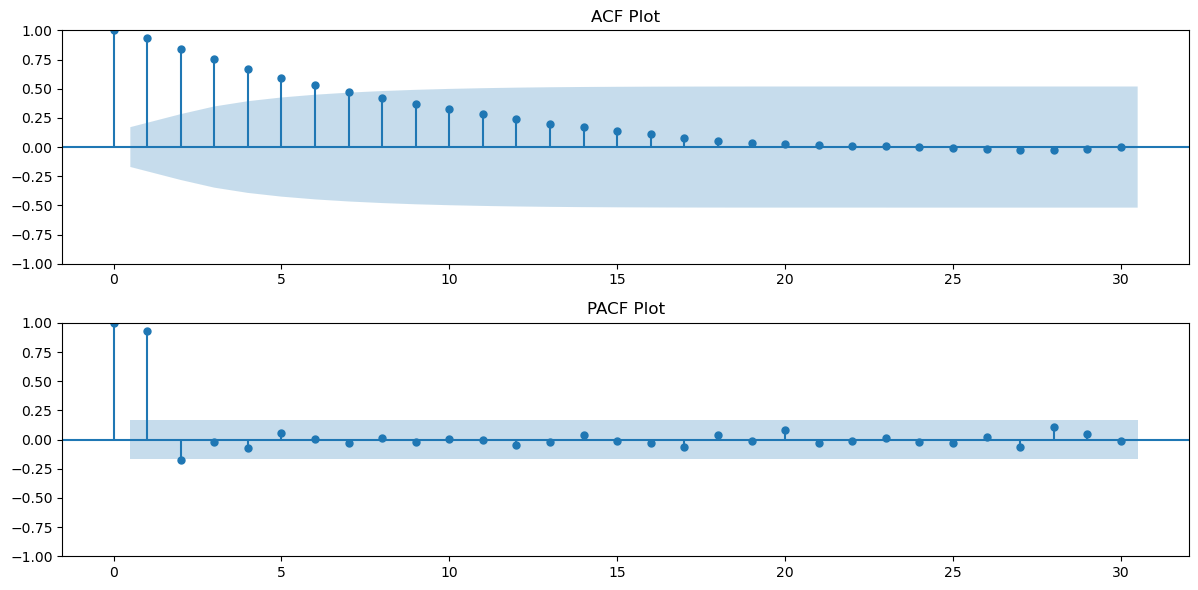

In [166]:
y = train;
max_lags = 30  

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(y, ax=plt.gca(), lags=max_lags, title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(y, ax=plt.gca(), lags=max_lags, title='PACF Plot')
plt.tight_layout()
plt.show()


## Model Selection

In [173]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress non-critical warnings

models = {
    'ARIMA(2,1,0)': (2, 1, 0),
    'ARIMA(2,1,1)': (2, 1, 1),
    'ARIMA(2,1,2)': (2, 1, 2),
    'ARIMA(1,1,1)': (1, 1, 1),
    'ARIMA(0,1,2)': (0, 1, 2),
    'ARIMA(1,1,2)': (1, 1, 2)
}

# Store all model results and diagnostics
model_results = []

for name, order in models.items():
    try:
        model = ARIMA(train, order=order).fit()
        print(f"\n{name} Summary:")
        print(model.summary())
        
        # Store model information for later analysis
        model_results.append({
            'name': name,
            'order': order,
            'model': model,
            'params': model.params,
            'pvalues': model.pvalues,
            'resid': model.resid
        })
    except Exception as e:
        print(f"Failed to fit {name}: {str(e)}")



ARIMA(2,1,0) Summary:
                               SARIMAX Results                                
Dep. Variable:                log_RER   No. Observations:                  132
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 368.105
Date:                Thu, 10 Apr 2025   AIC                           -730.211
Time:                        01:07:29   BIC                           -721.585
Sample:                    01-01-2013   HQIC                          -726.706
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1573      0.110      1.426      0.154      -0.059       0.373
ar.L2         -0.0470      0.065     -0.727      0.467      -0.174       0.080
sigma2         0.0002   2.12e

### Shortlisting model based on t-test

In [174]:
# Stage 1: T-test filtering
# shortlisted_models_stage1 = []

# for result in model_results:
#     # Check if all coefficients are significant (p < 0.05)
#     significant = all(p < 0.05 for p in result['pvalues'])
    
#     if significant:
#         shortlisted_models_stage1.append(result)
#         print(f"{result['name']} passes t-test stage (all coefficients significant)")
#     else:
#         print(f"{result['name']} fails t-test stage (insignificant coefficients)")

# print(f"\nStage 1 shortlisted models: {[m['name'] for m in shortlisted_models_stage1]}")

# relaxed t test to allow 1 insignificant coefficient
model_results = []

for name, order in models.items():
    try:
        model = ARIMA(train, order=order).fit()
        print(f"\n{name} Summary:")
        # print(model.summary())
        
        # Count insignificant coefficients (p > 0.05, excluding sigma2)
        insignificant_count = 0
        arma_terms = [key for key in model.pvalues.index if ('ar.L' in key) or ('ma.L' in key)]
        
        for term in arma_terms:
            if model.pvalues[term] > 0.05:
                insignificant_count += 1
        
        # Store model information with t-test evaluation
        model_results.append({
            'name': name,
            'order': order,
            'model': model,
            'params': model.params,
            'pvalues': model.pvalues,
            'resid': model.resid,
            'insignificant_count': insignificant_count,
            'passes_t_test': insignificant_count <= 1  # Allows 1 insignificant term
        })
        
        # Print t-test results
        print(f"T-test evaluation: {insignificant_count} insignificant terms")
        print(f"Passes relaxed t-test? {'Yes' if insignificant_count <= 1 else 'No'}")
        
    except Exception as e:
        print(f"Failed to fit {name}: {str(e)}")

# Print summary of t-test results
# Initialize the shortlist
shortlisted_models_stage1 = []

# Print and filter models based on t-test
print("\nT-test Results Summary:")
for result in model_results:
    # Print model status
    status = f"{result['name']}: {result['insignificant_count']} insignificant terms - " \
             f"{'Passes' if result['passes_t_test'] else 'Fails'} t-test"
    print(status)
    
    # Store passing models
    if result['passes_t_test']:
        shortlisted_models_stage1.append(result)
        print(f"  → Added to Stage 1 shortlist")

# Print shortlist summary
if shortlisted_models_stage1:
    print("\nStage 1 Shortlisted Models (passed t-test):")
    for model in shortlisted_models_stage1:
        print(f"- {model['name']} ({model['insignificant_count']} insignificant terms)")
else:
    print("\nNo models passed the t-test stage")


ARIMA(2,1,0) Summary:
T-test evaluation: 2 insignificant terms
Passes relaxed t-test? No

ARIMA(2,1,1) Summary:
T-test evaluation: 1 insignificant terms
Passes relaxed t-test? Yes

ARIMA(2,1,2) Summary:
T-test evaluation: 4 insignificant terms
Passes relaxed t-test? No

ARIMA(1,1,1) Summary:
T-test evaluation: 2 insignificant terms
Passes relaxed t-test? No

ARIMA(0,1,2) Summary:
T-test evaluation: 2 insignificant terms
Passes relaxed t-test? No

ARIMA(1,1,2) Summary:
T-test evaluation: 1 insignificant terms
Passes relaxed t-test? Yes

T-test Results Summary:
ARIMA(2,1,0): 2 insignificant terms - Fails t-test
ARIMA(2,1,1): 1 insignificant terms - Passes t-test
  → Added to Stage 1 shortlist
ARIMA(2,1,2): 4 insignificant terms - Fails t-test
ARIMA(1,1,1): 2 insignificant terms - Fails t-test
ARIMA(0,1,2): 2 insignificant terms - Fails t-test
ARIMA(1,1,2): 1 insignificant terms - Passes t-test
  → Added to Stage 1 shortlist

Stage 1 Shortlisted Models (passed t-test):
- ARIMA(2,1,1) (1 

#### Shortlisting model based on Q-test

In [234]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Stage 2: Q-test filtering
shortlisted_models_stage2 = []
lags_to_check = [4, 8, 12]  # multiple lags for Q-test

for result in shortlisted_models_stage1:
    # Perform Ljung-Box test on residuals for all specified lags
    lb_test = acorr_ljungbox(result['resid'], lags=lags_to_check, return_df=True)
    
    # Store Q-statistics and p-values
    result['ljung_box'] = {
        f"Q({lag})": {
            "stat": lb_test.loc[lag, 'lb_stat'],
            "p_value": lb_test.loc[lag, 'lb_pvalue']
        } for lag in lags_to_check
    }

    # Check if model passes Q-test at all lags
    p_values = [lb_test.loc[lag, 'lb_pvalue'] for lag in lags_to_check]
    passes_all = all(p > 0.05 for p in p_values)
    
    if passes_all:
        shortlisted_models_stage2.append(result)
        print(f"{result['name']} passes Q-test at lags {lags_to_check} (p-values = {[f'{p:.4f}' for p in p_values]})")
    else:
        print(f"{result['name']} fails Q-test at one or more lags (p-values = {[f'{p:.4f}' for p in p_values]})")

print(f"\nStage 2 shortlisted models: {[m['name'] for m in shortlisted_models_stage2]}")


ARIMA(2,1,1) passes Q-test at lags [4, 8, 12] (p-values = ['1.0000', '1.0000', '1.0000'])
ARIMA(1,1,2) passes Q-test at lags [4, 8, 12] (p-values = ['1.0000', '1.0000', '1.0000'])

Stage 2 shortlisted models: ['ARIMA(2,1,1)', 'ARIMA(1,1,2)']


#### Shortlisting model based on AIC/BIC

In [176]:
# Stage 3: AIC/BIC selection
if shortlisted_models_stage2:
    # Create DataFrame of model information
    selection_df = pd.DataFrame({
        'Model': [m['name'] for m in shortlisted_models_stage2],
        'AIC': [m['model'].aic for m in shortlisted_models_stage2],
        'BIC': [m['model'].bic for m in shortlisted_models_stage2],
        'Order': [m['order'] for m in shortlisted_models_stage2]
    }).sort_values('AIC')
    
    print("\nModel Selection Results:")
    print(selection_df)
    
    best_model = shortlisted_models_stage2[selection_df.index[0]]
    print(f"\nBest model based on selection process: {best_model['name']}")
    
    # You can now use best_model['model'] for forecasting
else:
    print("No models passed all selection stages. Consider revisiting model specifications.")


Model Selection Results:
          Model         AIC        BIC      Order
0  ARIMA(2,1,1) -729.805999 -718.30521  (2, 1, 1)
1  ARIMA(1,1,2) -729.778309 -718.27752  (1, 1, 2)

Best model based on selection process: ARIMA(2,1,1)


## Model Selection Tabular Visualisation

In [296]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Initialize storage for all model results
combined_results = []
lags_to_check = [4, 8, 12]  # Lags for Q-test
best_model = None
best_aic = float('inf')

# Stage 1: Comprehensive model evaluation
for name, order in models.items():
    try:
        model = ARIMA(train, order=order).fit()
        
        # T-test evaluation
        insignificant_count = 0
        arma_terms = [key for key in model.pvalues.index if ('ar.L' in key) or ('ma.L' in key)]
        
        for term in arma_terms:
            if model.pvalues[term] > 0.05:
                insignificant_count += 1
        
        # Q-test evaluation
        lb_test = acorr_ljungbox(model.resid, lags=lags_to_check, return_df=True)
        q_passes = all(lb_test['lb_pvalue'] > 0.05)
        
        # Check if current model is the best so far
        is_best = False
        if insignificant_count <= 1 and q_passes:
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = {
                    'name': name,
                    'order': order,
                    'model': model,
                    'resid': model.resid
                }
                is_best = True
        
        # Store combined results
        model_result = {
            'Model': name,
            'Order': str(order),
            'AR.L1.pval': model.pvalues.get('ar.L1', 1),
            'AR.L2.pval': model.pvalues.get('ar.L2', 1),
            'MA.L1.pval': model.pvalues.get('ma.L1', 1),
            'MA.L2.pval': model.pvalues.get('ma.L2', 1),
            'Insignificant Terms': insignificant_count,
            'Passes T-test': insignificant_count <= 1,
            'AIC': model.aic,
            'BIC': model.bic,
            **{f'Q({lag})_stat': lb_test.loc[lag, 'lb_stat'] for lag in lags_to_check},
            **{f'Q({lag})_pval': lb_test.loc[lag, 'lb_pvalue'] for lag in lags_to_check},
            'Passes All Q-tests': q_passes,
            'Qualified Model': (insignificant_count <= 1 and q_passes),
            'Best Model': is_best
        }
        
        combined_results.append(model_result)
        
    except Exception as e:
        print(f"Failed to fit {name}: {str(e)}")

# Create combined DataFrame
combined_df = pd.DataFrame(combined_results)

# Formatting functions
def color_pval(val):
    if isinstance(val, float):
        return 'color: red' if val > 0.05 else 'color: green'
    return ''
def color_lval(val):
    if isinstance(val, float):
        return 'color: green' if val > 0.5 else 'color: black'
    return ''

def highlight_best(row):
    return ['background-color: lightgreen' if row['Best Model'] else '' for _ in row]

# Create styled table
styled_table = (
    combined_df.style
    .format({
        'AR.L1.pval': '{:.3f}',
        'AR.L2.pval': '{:.3f}',
        'MA.L1.pval': '{:.3f}',
        'MA.L2.pval': '{:.3f}',
        'AIC': '{:.1f}',
        'BIC': '{:.1f}',
        **{f'Q({lag})_stat': '{:.2f}' for lag in lags_to_check},
        **{f'Q({lag})_pval': '{:.4f}' for lag in lags_to_check}
    })
    .map(color_pval, subset=['AR.L1.pval', 'AR.L2.pval', 'MA.L1.pval', 'MA.L2.pval'])
    .map(color_lval, subset=[f'Q({lag})_pval' for lag in lags_to_check])
    .apply(highlight_best, axis=1)
    .set_caption('Comprehensive ARIMA Model Evaluation with Best Model Highlighted')
)

# Display results
print("=== COMPREHENSIVE MODEL EVALUATION ===")
display(styled_table)
# Show final selection
if best_model:
    print("\n=== FINAL SELECTION ===")
    print(f"Best Model: {best_model['name']}")
    print(f"Order: {best_model['order']}")
    print(f"AIC: {best_model['model'].aic:.1f}")
    print(f"BIC: {best_model['model'].bic:.1f}")
    print("\nKey Statistics:")
    print(f"- Insignificant terms: {combined_df.loc[combined_df['Best Model'], 'Insignificant Terms'].values[0]}")
    print(f"- Q-test p-values: {[combined_df.loc[combined_df['Best Model'], f'Q({lag})_pval'].values[0] for lag in lags_to_check]}")
else:
    print("\nNo models qualified as best model. Consider:")
    print("- Relaxing selection criteria")
    print("- Trying different model orders")
    print("- Checking for data issues")

=== COMPREHENSIVE MODEL EVALUATION ===


,Model,Order,AR.L1.pval,AR.L2.pval,MA.L1.pval,MA.L2.pval,Insignificant Terms,Passes T-test,AIC,BIC,Q(4)_stat,Q(8)_stat,Q(12)_stat,Q(4)_pval,Q(8)_pval,Q(12)_pval,Passes All Q-tests,Qualified Model,Best Model
0,"ARIMA(2,1,0)","(2, 1, 0)",0.154,0.467,1.000,1.000,2,False,-730.2,-721.6,0.00,0.05,0.07,1.0000,1.0000,1.0000,True,False,False
1,"ARIMA(2,1,1)","(2, 1, 1)",0.014,0.598,0.000,1.000,1,True,-729.8,-718.3,0.01,0.05,0.07,1.0000,1.0000,1.0000,True,True,True
2,"ARIMA(2,1,2)","(2, 1, 2)",0.980,0.829,0.935,0.848,4,False,-727.6,-713.2,0.01,0.05,0.07,1.0000,1.0000,1.0000,True,False,False
3,"ARIMA(1,1,1)","(1, 1, 1)",0.592,1.000,0.297,1.000,2,False,-730.5,-721.9,0.00,0.05,0.07,1.0000,1.0000,1.0000,True,False,False
4,"ARIMA(0,1,2)","(0, 1, 2)",1.000,1.000,0.216,0.567,2,False,-730.3,-721.7,0.00,0.05,0.07,1.0000,1.0000,1.0000,True,False,False
5,"ARIMA(1,1,2)","(1, 1, 2)",0.019,1.000,0.006,0.664,1,True,-729.8,-718.3,0.01,0.05,0.07,1.0000,1.0000,1.0000,True,True,False



=== FINAL SELECTION ===
Best Model: ARIMA(2,1,1)
Order: (2, 1, 1)
AIC: -729.8
BIC: -718.3

Key Statistics:
- Insignificant terms: 1
- Q-test p-values: [0.9999968751294732, 0.9999999892666701, 0.9999999999982766]


## Forecasting using the best fit model

2024-01-01    3.960080
2024-02-01    3.959304
2024-03-01    3.959867
2024-04-01    3.959453
2024-05-01    3.959757
2024-06-01    3.959533
2024-07-01    3.959697
2024-08-01    3.959577
2024-09-01    3.959665
2024-10-01    3.959600
2024-11-01    3.959648
2024-12-01    3.959613
Freq: MS, Name: predicted_mean, dtype: float64
2024-01-01    52.461499
2024-02-01    52.420825
2024-03-01    52.450324
2024-04-01    52.428621
2024-05-01    52.444565
2024-06-01    52.432850
2024-07-01    52.441457
2024-08-01    52.435133
2024-09-01    52.439779
2024-10-01    52.436365
2024-11-01    52.438874
2024-12-01    52.437031
Freq: MS, Name: predicted_mean, dtype: float64


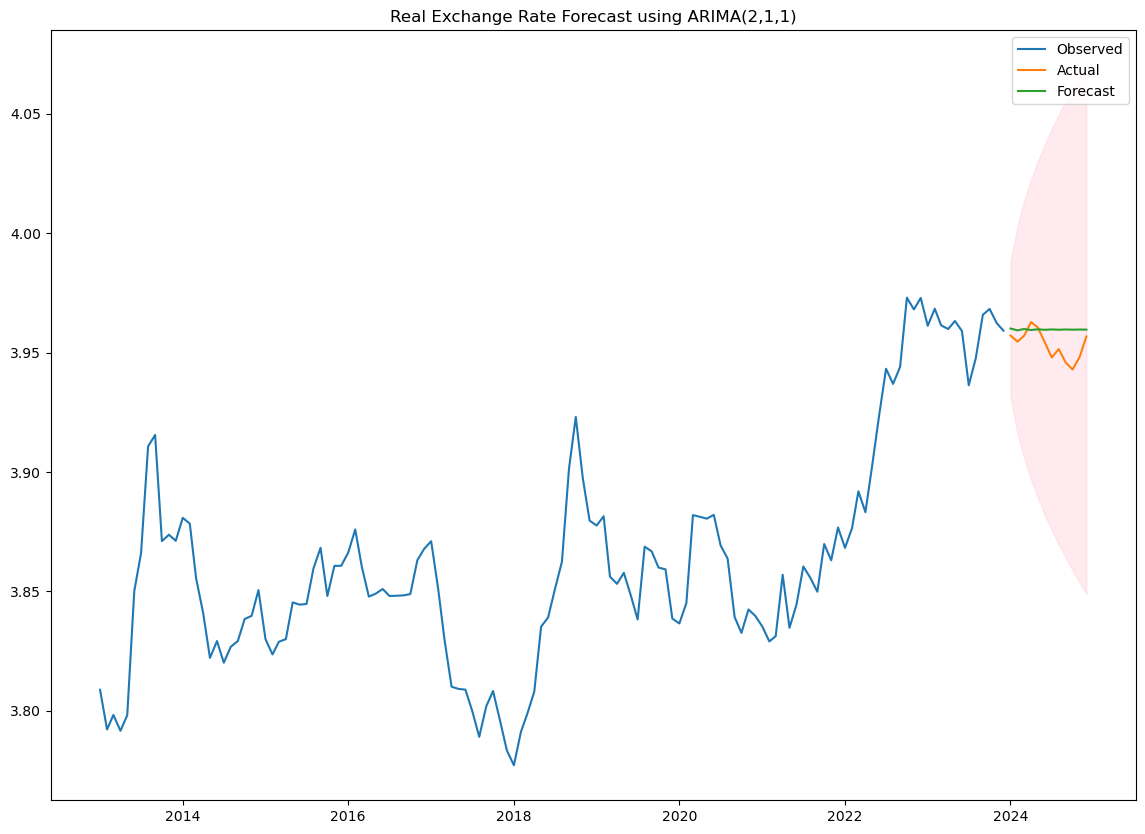

Model Evaluation on Test Data:
MSE  = 0.000075
MAE  = 0.007063
RMSE = 0.008640


In [200]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

if shortlisted_models_stage2:
    # Generate forecasts
    forecast_steps = len(test)  # Adjust as needed
    forecast = best_model['model'].get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_mean_original = np.exp(forecast_mean) 
    print(forecast_mean)
    print(forecast_mean_original)
    confidence_intervals = forecast.conf_int()
    
    # model evaluation on test data
    mse = mean_squared_error(test, forecast_mean)
    mae = mean_absolute_error(test, forecast_mean)
    rmse = np.sqrt(mse)
    
    # Plot forecasts
    plt.figure(figsize=(14, 10))
    plt.plot(train, label='Observed')
    plt.plot(test, label='Actual')
    plt.plot(forecast_mean, label='Forecast')
    plt.fill_between(confidence_intervals.index,
                    confidence_intervals.iloc[:, 0],
                    confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Real Exchange Rate Forecast using {best_model["name"]}')
    plt.legend()
    plt.show()
    
    print("Model Evaluation on Test Data:")
    print(f"MSE  = {mse:.6f}")
    print(f"MAE  = {mae:.6f}")
    print(f"RMSE = {rmse:.6f}")